In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve

In [2]:
import os
os.chdir("/kaggle/input/pima-indians-diabetes-database/")

Diabetes is a chronic, metabolic disease characterized by elevated levels of blood glucose (or blood sugar), which leads over time to serious damage to the heart, blood vessels, eyes, kidneys and nerves (WHO 2022). Identifying the disease early could improve the health of the pearson so a classification algorithm based on health measures would be usefull.

With the data set *pima indians diabetes* which contains data such as blood preasure, Body mass index, times pregnant and other health indicators, with Support Vector Classifier and Logistic Regression classify if a woman has diabetes or not. The idea is cuantify the acurracy of both methods in detecting if a woman has diabetes or not.

In [3]:
diabetes=pd.read_csv("diabetes.csv")
diabetes.Outcome = diabetes.Outcome.replace({0:'Non-Diab',1:'Diab'})
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,Diab
1,1,85,66,29,0,26.6,0.351,31,Non-Diab
2,8,183,64,0,0,23.3,0.672,32,Diab
3,1,89,66,23,94,28.1,0.167,21,Non-Diab
4,0,137,40,35,168,43.1,2.288,33,Diab


In [4]:
diabetes.shape

(768, 9)

In [5]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


We have eight variables and 768 women, the descriptive analysis show some wear values, the minimum value of Blood preasure, BMI, Skin, Glucose and Insulin is 0 and that does not make sense, so we drop those observations.

In [6]:
diabetes2=diabetes[(diabetes.Glucose!=0)&(diabetes.BloodPressure!=0)&(diabetes.SkinThickness!=0)&(diabetes.Insulin!=0)&(diabetes.BMI!=0)]

In [7]:
diabetes2.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000


The descriptive analysis of the new dataset has sense, using this new data set, the models are estimated and tested.

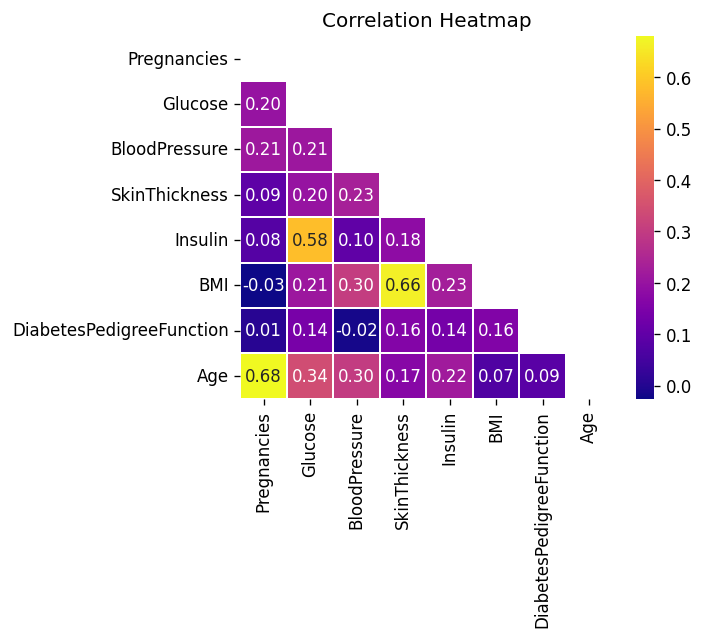

In [8]:
plt.figure(dpi = 120,figsize= (5,4))
mask = np.triu(np.ones_like(diabetes2.corr(),dtype = bool))
sns.heatmap(diabetes2.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

There exist a highe correlation between age and pregnancies, skin thickness and BMI, Glucose and Insulin, those correlations were expected.

In [9]:
X=diabetes[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'Age']]
y=diabetes[["Outcome"]]

In [10]:
X_norm=StandardScaler().fit_transform(X)

In [11]:
pca = PCA(n_components=2)
pca.fit(X_norm)

PCA(n_components=2)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

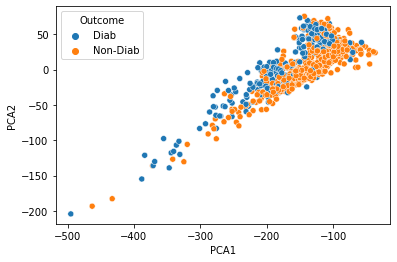

In [12]:
components=pca.transform(X)
df_Components = pd.DataFrame(data = components, 
                     columns = ["PCA1","PCA2"])
df_Components["Outcome"]=diabetes["Outcome"]
sns.scatterplot(x="PCA1",y="PCA2",hue="Outcome",data=df_Components)

Using 2 components of PCA to see how can be separeted in non diabetic and diabetic, it seems like a line con make a good division, we are going to corroborate this with a kernel cross validation.

In [13]:
y=pd.get_dummies(diabetes.Outcome)
y=y.Diab

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_norm,y)

In [15]:
parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1, 10,100,1000]}
svc=SVC()
clf = GridSearchCV(SVC(probability=True), parameters,refit=True)
clf.fit(X_train,y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [1, 10, 100, 1000],
                         'kernel': ('linear', 'rbf', 'sigmoid')})

The best kernel is the Radial basis function kernel with a C parameter 10

In [16]:
svc_predict=clf.predict(X_test)

In [17]:
output=pd.concat([pd.DataFrame(svc_predict),pd.DataFrame(y_test.values)],axis=1,ignore_index=False)
output.columns=["Predict value","Real value"]

In [18]:
nlscores=clf.predict_proba(X_test)

In [19]:
fpr, tpr, thresholds =roc_curve(y_test,nlscores[:,1])

In [20]:
parameters = {'C':[1, 10,100,1000]}
lr = GridSearchCV(LogisticRegression(), parameters,refit=True)
lr.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100, 1000]})

In [21]:
lr_pred=lr.predict(X_test)
lr_prob=lr.predict_proba(X_test)

In [22]:
fpr_lr, tpr_lr, thresholds_lr =roc_curve(y_test,lr_prob[:,1])

With the ROC curve the models can be compared, the logistic regression has a better performance that Support Vector Clasifier with a rbf kernel

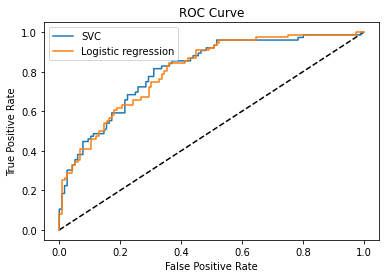

In [23]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr,label="SVC")
plt.plot(fpr_lr, tpr_lr,label="Logistic regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [24]:
lr.score(X_test,y_test)

0.7239583333333334

In [25]:
print(clf.score(X_test,y_test))

0.71875


Using the seven variables a better algorithm to identify the diabetes in a woman is a logistic regression, showing an accuracy of 73\%, being glucose, insulin and BMI the most important variables.